**Importando Bibliotecas**

In [1]:
import pandas as pd;
import numpy as np;
import matplotlib.pyplot as plt;
import warnings;
from statsmodels.tsa.api import (kpss, adfuller, seasonal_decompose, STL);
from statsmodels.tools.eval_measures import rmse, rmspe;
from sklearn.metrics import mean_absolute_percentage_error as mape;
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf;
from itertools import product;
from pathlib import Path;

warnings.filterwarnings('ignore');
plt.rcParams['figure.figsize'] = [12,5]

**Importando os datasets**

In [2]:
arquivo_life = Path('life_expectancy_birth.csv');
arquivo_milk = Path('milk_production.csv');

life = pd.read_csv(arquivo_life, index_col='year', parse_dates=True, skipfooter=1);
milk = pd.read_csv(arquivo_milk, index_col='month', parse_dates=True);

In [3]:
life.head()

,value
year,
1960-01-01,69.123902
1961-01-01,69.760244
1962-01-01,69.149756
1963-01-01,69.248049
1964-01-01,70.311707


In [4]:
milk.head()

,production
month,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


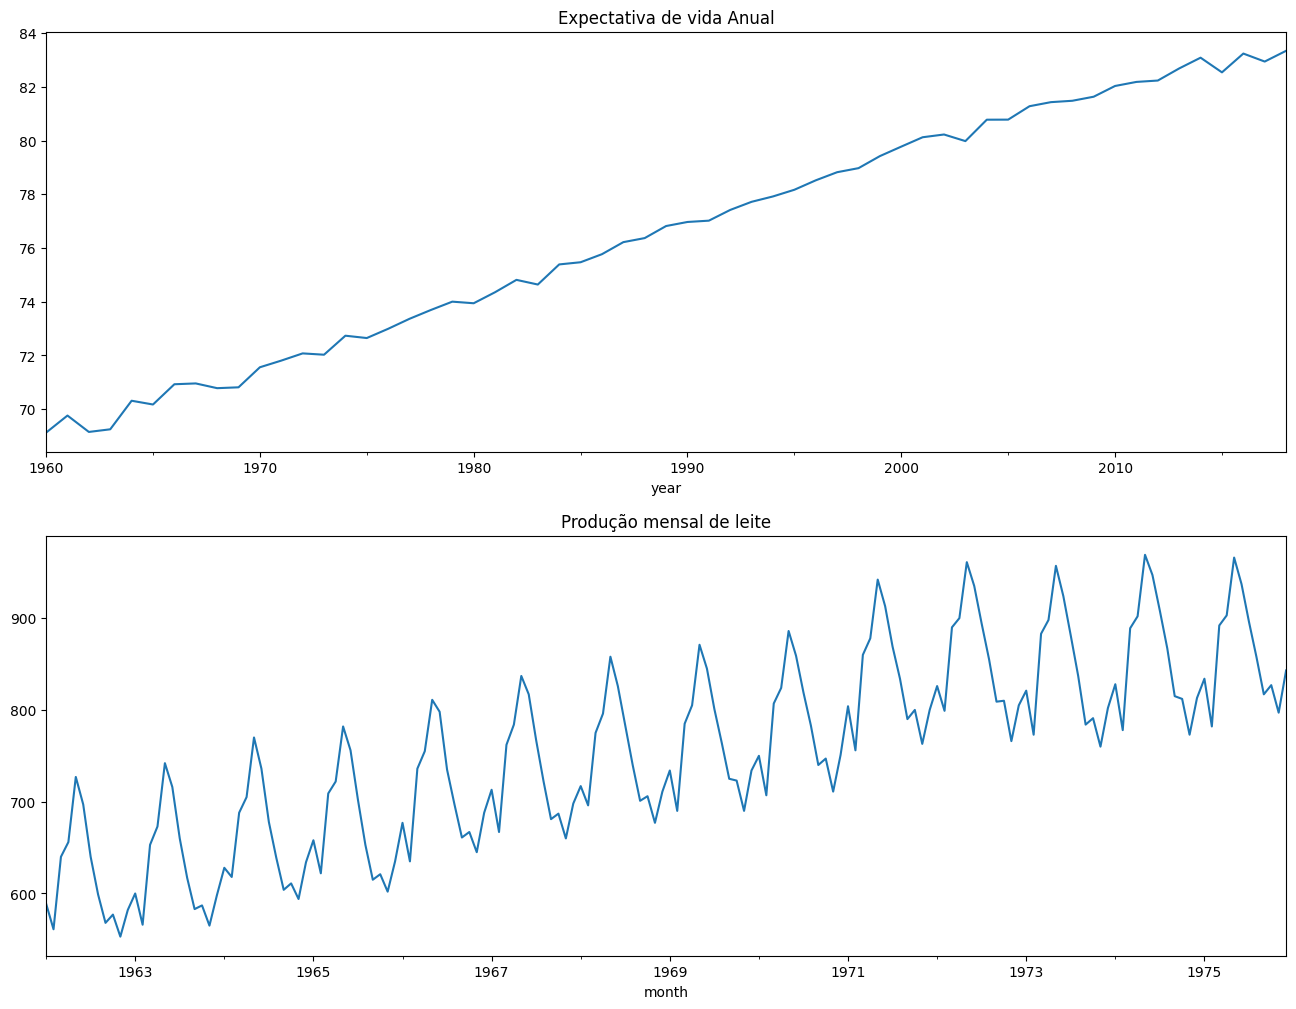

In [6]:
fig, ax = plt.subplots(2, 1, figsize = (16, 12));
life.plot(title='Expectativa de vida Anual', legend=False, ax=ax[0]);
milk.plot(title='Produção mensal de leite', legend=False, ax=ax[1]);

In [8]:
def split_data(data, test_split):
    l = len(data);
    t_idx = round(l * (1 - test_split));
    train, test = data [ : t_idx ], data[t_idx: ];
    print(f'treino: {len(train)}, Teste: {len(test)}');
    return train, test;


**Chamada para a função *split_data* para dividir os dois DATAFRAMES em test e train.**

In [9]:
test_split = 0.15;
milk_train, milk_test = split_data ( milk, test_split);
life_train, life_test = split_data ( life, test_split);


treino: 143, Teste: 25
treino: 50, Teste: 9


In [19]:
def check_stationarity(df):
    results = adfuller(df)[1:3];
    s = 'Não Estacionaria';
    if results[0] < 0.05:
        s = 'Estacionaria';
    print(f"'{s}\t p-valor: {results[0]}\t lags: {results[1]}'");
    return (s, results[0]);

In [11]:
def get_best_model(score, c='AIC'):
    initial_score = score[0][c];
    best_model = 0;
    for k, v in score.items():
        if v[c] < initial_score:
            initial_score = v[c];
            best_model = k;
    print(f'Melhor modelo é: {best_model} com menor {c} score: {initial_score}');
    return score[best_model]['model']

In [12]:
def plot_forecast ( model , start, train, test):
    forecast = pd.DataFrame(model.forecast(test.shape[0]), index=test.index);
    ax = train.loc[start: ].plot(style = '--');
    ax.legend(['orig_train', 'orig_test', 'forecast']);
    plt.show();

In [13]:
def combinator(items):
    combo = [i for i in product(*items)];
    return combo;

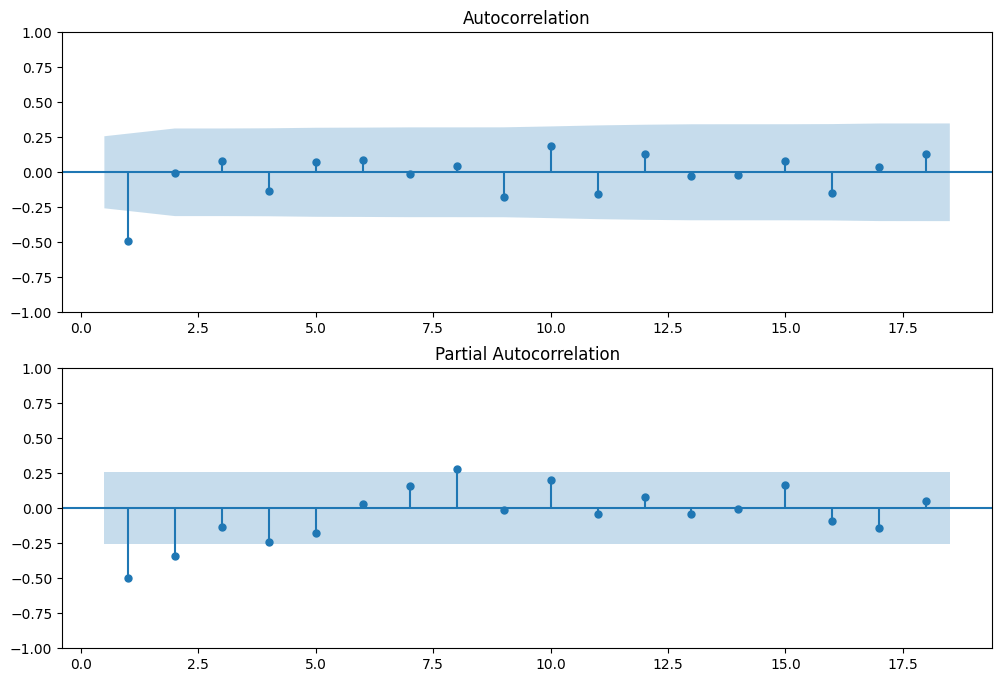

In [14]:
life_diff = life.diff().dropna();
fig, ax = plt.subplots(2, 1, figsize=(12,8));
plot_acf(life_diff, zero=False, ax=ax[0]);
plot_pacf(life_diff, zero=False, ax=ax[1]);
plt.show()

In [16]:
milk_diff_12 = milk.diff(12).dropna();

In [18]:
milk_diff_12

,production
month,
1963-01-01,11.0
1963-02-01,5.0
1963-03-01,13.0
1963-04-01,17.0
1963-05-01,15.0
...,...
1975-08-01,-9.0
1975-09-01,2.0
1975-10-01,15.0


In [20]:
check_stationarity(milk_diff_12);

'Não Estacionaria	 p-valor: 0.1607988052771125	 lags: 12'


('Não Estacionaria', 0.1607988052771125)

In [21]:
milk_diff_12_1 = milk.diff(12).diff(1).dropna();
check_stationarity(milk_diff_12_1);

'Estacionaria	 p-valor: 1.865423431878848e-05	 lags: 11'


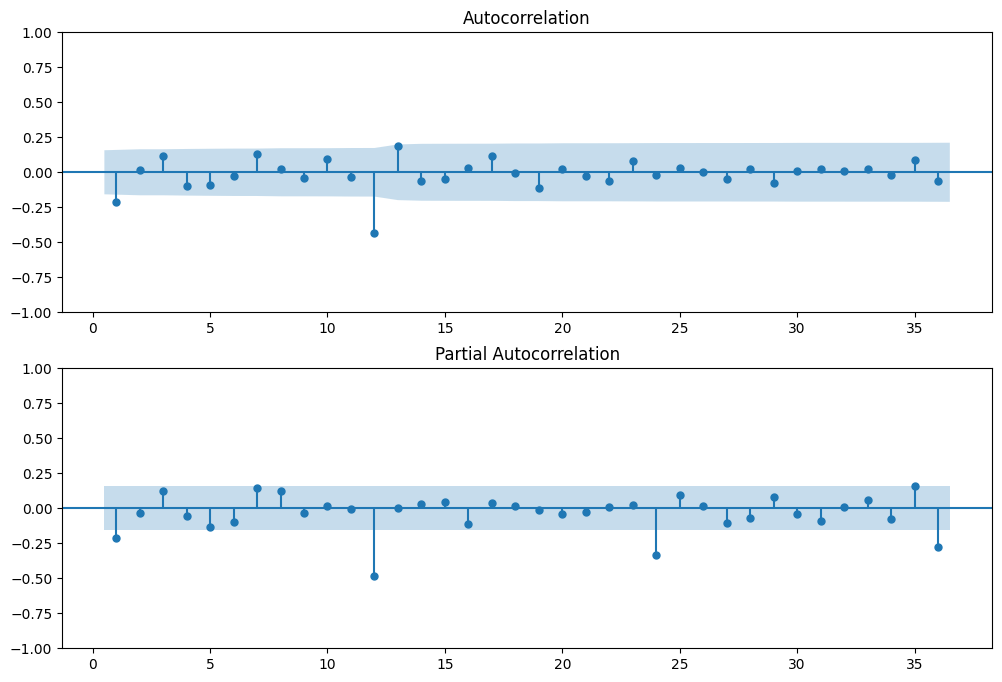

In [23]:
fig, ax = plt.subplots(2, 1, figsize=(12,8));
plot_acf(milk_diff_12_1, zero=False, ax=ax[0], lags=36);
plot_pacf(milk_diff_12_1, zero=False, ax=ax[1], lags=36);
plt.show()